# **Imports**

In [1]:
!pip install --upgrade pip
!pip install gensim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import requests
import string
import re

from sklearn.manifold import TSNE

import nltk
nltk.download('punkt')
from nltk import word_tokenize, tokenize
from nltk.tokenize import sent_tokenize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from statistics import variance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

In [4]:

from sklearn.neural_network import MLPClassifier


# **Functions**

In [5]:
def vectoring(table):
  table = remove_abstract(table, 'text', pattern)
  get_unique_info(table, 'text', pattern)
  table['text_one_vec'] = table['text_vector_list'].apply(sum)
  table = add_feat(table, 'text_one_vec')
  table = table.drop(['text_unique_words', 'text_one_vec', 'text_vector_list'], axis = 1)
  matrix = td_idf_vec.transform(table['text'])

  matrix = hstack([matrix, csr_matrix(table['avg']).reshape(-1,1), csr_matrix(table['var']).reshape(-1,1)])
  for i in range(300):
    matrix = hstack([matrix, csr_matrix(table[f'text_one_vec_dim_{i}']).reshape(-1,1)])
  return matrix

In [6]:
def len_sent(texts):
  tooks = sent_tokenize(texts)
  total = 0
  for i in tooks:
    total += len(word_tokenize(i))
  return total/len(tooks)



In [7]:
def find_var(texts):
  sens = []
  tooks = sent_tokenize(texts)
  for i in tooks:
    sens += [len(word_tokenize(i))]
  if len(sens) < 2:
    return 0
  else :
    return variance(sens)

In [8]:
def add_ins(table):
  table['avg'] = table['text'].apply(len_sent)
  table['var'] = table['text'].apply(find_var)
  return table

In [9]:
def remove_abstract(df, col, pattern):
  rem = []
  for i in range(len(df)):
    tokenized_raw = ' '.join(nltk.regexp_tokenize(df[col][i], pattern))
    tokenized_raw = tokenize.sent_tokenize(tokenized_raw)

    if len(tokenized_raw) == 0 or tokenized_raw[0] in string.punctuation:
      df = df.drop(i)
      continue

    rem.append(re.sub('(\\n)+', ' ', df[col][i]))

  df[col] = rem
  return df.reset_index().drop(columns = 'index')

In [10]:
def get_unique_info(df, col, pattern):
  unique = []
  length = []
  vec = []

  for i in range(len(df)):
    tokenized_raw = ' '.join(nltk.regexp_tokenize(df[col][i], pattern))
    tokenized_raw = tokenize.sent_tokenize(tokenized_raw)

    nopunct = []

    for sent in tokenized_raw:
      a = [w for w in sent.split() if w not in string.punctuation]
      nopunct.append(' '.join(a))

    tok_corp = [nltk.word_tokenize(sent) for sent in nopunct]

    model = gensim.models.Word2Vec(tok_corp, min_count = 1, vector_size = 300, window = 5)

    unique_words = list(set([item for sublist in tok_corp for item in sublist]))

    vector_list = model.wv[unique_words]

    unique.append(unique_words)
    length.append(len(unique_words))
    vec.append(vector_list)

  df[col + '_vector_list'] = vec
  df[col + '_unique_words'] = unique
  df[col + '_len_unique_words'] = length

In [11]:
def add_feat(df, col):
  dims = np.zeros(shape = (len(df[col][0]), len(df)))

  for i in range(len(df[col])):
    for j in range(len(df[col][i])):
      dims[j][i] = df[col][i][j]

  for dim in range(len(dims)):
    temp = df.copy()
    temp[col + '_dim_' + str(dim)] = dims[dim]
    df = temp
  return df

# **Cleaning**

In [12]:
data = pd.read_csv('train_drcat_03.csv')

In [73]:
data_copy = pd.read_csv('train_drcat_03.csv')

In [13]:
data.head()

,essay_id,text,label,source,prompt,fold
0,6BB4BEB51A80,People can learn without making mistakes. Peop...,0,original_moth,Task: \n\nWrite an essay examining the ways in...,1
1,30A8FB981469,PHONES AND DRIVING\n\nIn this world in which w...,0,persuade_corpus,NaN,2
2,B403A4E28BCE,"Okay, here's my essay:\n\nMaking Your Own Deci...",1,llama2_chat,Task: Write an essay exploring why teenagers s...,8
3,B8F0ECC9DC86,Dear : Principal\n\nI believe that allowing s...,1,mistral7binstruct_v2,\nTask: Should students be encouraged to parti...,8
4,159424F57C24,Well for one if you seek more then one person ...,0,persuade_corpus,NaN,8


In [14]:
data = data[['text', 'label']]
data = data.sample(n=10000, random_state=42)

# **EDA**

In [15]:
# Creates Avg Sentence Length and Variance of Sentence Lenght Variables
data = add_ins(data)
data

,text,label,avg,var
33406,Everyone knows that a teenagers emotion can ch...,0,25.000000,127.789474
7,Imagine constantly coughing. Would you like th...,0,12.914894,78.818686
29590,Changing our ways on how we use cars for the b...,0,17.697674,96.073090
41022,This technology should not be used in a classr...,0,23.181818,138.963636
25073,In this passage it introduces this mission on ...,0,20.384615,41.256410


Text(0, 0.5, 'Number of Instances')

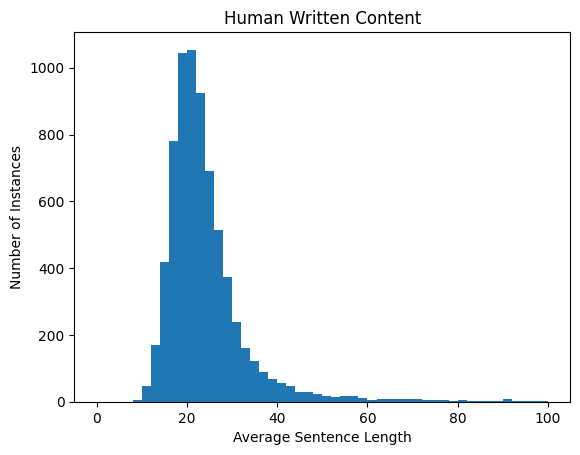

In [16]:
plt.hist(data[data['label'] == 0]['avg'], bins = 50, range = (0,100))
plt.title('Human Written Content')
plt.xlabel('Average Sentence Length')
plt.ylabel('Number of Instances')

Text(0, 0.5, 'Number of Instances')

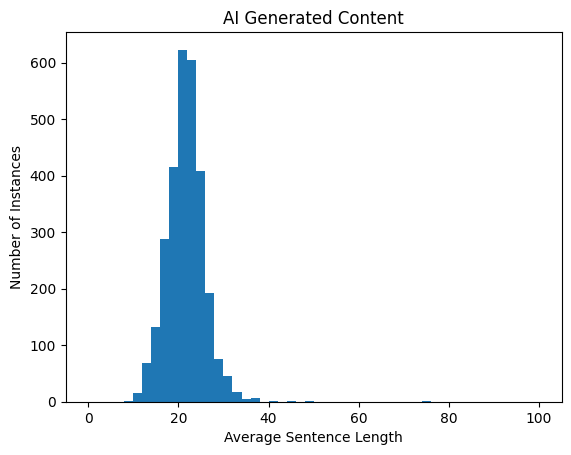

In [17]:
plt.hist(data[data['label'] == 1]['avg'], bins = 50, range = (0,100))
plt.title('AI Generated Content')
plt.xlabel('Average Sentence Length')
plt.ylabel('Number of Instances')

Text(0, 0.5, 'Number of Instances')

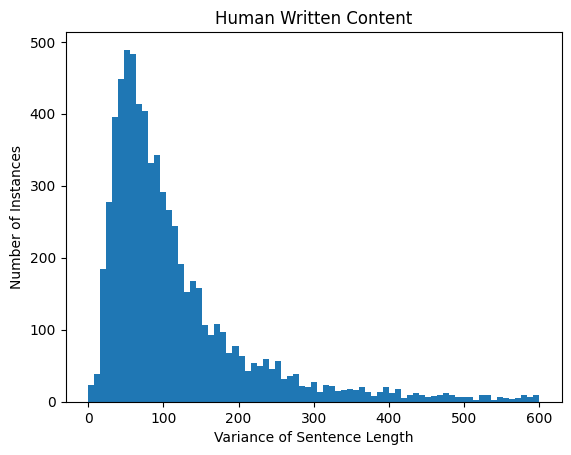

In [18]:
plt.hist(data[data['label'] == 0]['var'], bins = 75, range = (0,600))
plt.title('Human Written Content')
plt.xlabel('Variance of Sentence Length')
plt.ylabel('Number of Instances')

Text(0, 0.5, 'Number of Instances')

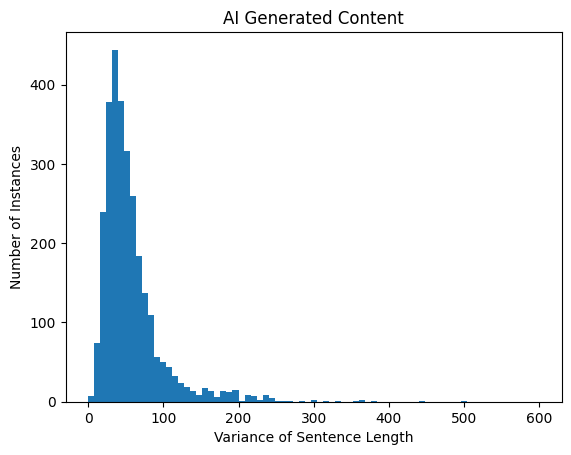

In [19]:
plt.hist(data[data['label'] == 1]['var'], bins = 75, range = (0,600))
plt.title('AI Generated Content')
plt.xlabel('Variance of Sentence Length')
plt.ylabel('Number of Instances')

# **Vectorizing**

In [20]:
pattern = r'''(?x)
(?:[A-Z]\.)+
|\w+(?:[-']\w+)*
|\$?\d+(?:\.\d+)?
|\.\.\.
|[.,;"'?()-_`]
'''

In [21]:
#Need 0 indexed DataFrame
data = data.copy().reset_index().drop(columns = 'index')

In [22]:
#Removes any rows with sentences that start with symbol like ?!.#
data = remove_abstract(data, 'text', pattern)

In [23]:
#Finds the list of unique words and creates a list of vectors for the unique words in the text
get_unique_info(data, 'text', pattern)
data.head()

,text,label,avg,var,text_vector_list,text_unique_words,text_len_unique_words
0,Everyone knows that a teenagers emotion can ch...,0,25.000000,127.789474,"[[-0.0026018142, -0.0027049547, 0.000373381, -...","[would, knowing, I, yet, disagree, with, enoug...",204
1,Imagine constantly coughing. Would you like th...,0,12.914894,78.818686,"[[0.0021142222, -0.0029256935, 0.00091006263, ...","[few, diesel, separate, license, sell, outcome...",284
2,Changing our ways on how we use cars for the b...,0,17.697674,96.073090,"[[-0.0011024461, 0.00047393586, 0.0018752251, ...","[fun, taxi, with, harm, path, gases, heart, fr...",324
3,This technology should not be used in a classr...,0,23.181818,138.963636,"[[0.0011792798, -0.0024781618, -0.00024571162,...","[judging, would, environment, give, tremendous...",127
4,In this passage it introduces this mission on ...,0,20.384615,41.256410,"[[0.0030318578, 0.0029723428, -0.0020549065, 0...","[few, earth, which, would, referred, dangers, ...",137


In [28]:
#Sums the vectors in the list into a single vectors of 300 dimensions
data['one_vec'] = data['text_vector_list'].apply(sum)

In [29]:
#Splits the One_Vec out into its parts, making a column for each diminsion
data = add_feat(data, 'one_vec')
data.head()

,text,label,avg,var,text_vector_list,text_unique_words,text_len_unique_words,one_vec,one_vec_dim_0,one_vec_dim_1,...,one_vec_dim_290,one_vec_dim_291,one_vec_dim_292,one_vec_dim_293,one_vec_dim_294,one_vec_dim_295,one_vec_dim_296,one_vec_dim_297,one_vec_dim_298,one_vec_dim_299
0,Everyone knows that a teenagers emotion can ch...,0,25.000000,127.789474,"[[-0.0026018142, -0.0027049547, 0.000373381, -...","[would, knowing, I, yet, disagree, with, enoug...",204,"[0.010060723, 0.07070004, -0.008147925, 0.0186...",0.010061,0.070700,...,-0.001583,0.047215,0.009607,-0.005746,0.030560,0.059775,-0.011124,-0.056832,0.017351,-0.006678
1,Imagine constantly coughing. Would you like th...,0,12.914894,78.818686,"[[0.0021142222, -0.0029256935, 0.00091006263, ...","[few, diesel, separate, license, sell, outcome...",284,"[0.009944089, 0.063875355, -0.0019884084, 0.03...",0.009944,0.063875,...,-0.004318,0.048897,0.038673,-0.038166,0.056515,0.084166,0.013859,-0.056797,0.013632,-0.018263
2,Changing our ways on how we use cars for the b...,0,17.697674,96.073090,"[[-0.0011024461, 0.00047393586, 0.0018752251, ...","[fun, taxi, with, harm, path, gases, heart, fr...",324,"[0.0058261743, 0.08894394, -0.0008516612, 0.05...",0.005826,0.088944,...,-0.033991,0.064760,0.028831,-0.016467,0.045703,0.081560,-0.008591,-0.058349,0.025120,-0.039160
3,This technology should not be used in a classr...,0,23.181818,138.963636,"[[0.0011792798, -0.0024781618, -0.00024571162,...","[judging, would, environment, give, tremendous...",127,"[-0.0056946524, 0.03491437, -0.014570651, 0.00...",-0.005695,0.034914,...,0.005002,0.050708,-0.003789,0.020889,0.029388,0.028140,0.001584,-0.012694,0.022728,-0.012375
4,In this passage it introduces this mission on ...,0,20.384615,41.256410,"[[0.0030318578, 0.0029723428, -0.0020549065, 0...","[few, earth, which, would, referred, dangers, ...",137,"[-0.0051351236, 0.047050893, -0.0056076245, 0....",-0.005135,0.047051,...,0.000199,0.051567,-0.001428,0.011534,0.039710,0.044441,-0.010765,-0.023672,0.009382,0.002221


In [30]:
data.shape

(9999, 308)

In [31]:
data = data.drop(['text_vector_list', 'text_unique_words', 'text_len_unique_words'], axis = 1)

In [32]:
data = data.drop('one_vec', axis = 1)
data.head()

,text,label,avg,var,one_vec_dim_0,one_vec_dim_1,one_vec_dim_2,one_vec_dim_3,one_vec_dim_4,one_vec_dim_5,...,one_vec_dim_290,one_vec_dim_291,one_vec_dim_292,one_vec_dim_293,one_vec_dim_294,one_vec_dim_295,one_vec_dim_296,one_vec_dim_297,one_vec_dim_298,one_vec_dim_299
0,Everyone knows that a teenagers emotion can ch...,0,25.000000,127.789474,0.010061,0.070700,-0.008148,0.018619,-0.000607,-0.040308,...,-0.001583,0.047215,0.009607,-0.005746,0.030560,0.059775,-0.011124,-0.056832,0.017351,-0.006678
1,Imagine constantly coughing. Would you like th...,0,12.914894,78.818686,0.009944,0.063875,-0.001988,0.032554,0.036462,-0.044125,...,-0.004318,0.048897,0.038673,-0.038166,0.056515,0.084166,0.013859,-0.056797,0.013632,-0.018263
2,Changing our ways on how we use cars for the b...,0,17.697674,96.073090,0.005826,0.088944,-0.000852,0.052229,0.039534,-0.041821,...,-0.033991,0.064760,0.028831,-0.016467,0.045703,0.081560,-0.008591,-0.058349,0.025120,-0.039160
3,This technology should not be used in a classr...,0,23.181818,138.963636,-0.005695,0.034914,-0.014571,0.008824,0.008032,-0.021577,...,0.005002,0.050708,-0.003789,0.020889,0.029388,0.028140,0.001584,-0.012694,0.022728,-0.012375
4,In this passage it introduces this mission on ...,0,20.384615,41.256410,-0.005135,0.047051,-0.005608,0.006213,-0.003028,-0.020762,...,0.000199,0.051567,-0.001428,0.011534,0.039710,0.044441,-0.010765,-0.023672,0.009382,0.002221


In [33]:
#This will transform Text column into TD_IDF matrix.
#TD = (# of times x appears)
td_idf_vec = TfidfVectorizer()

In [37]:
#This is the training data features
data.iloc[:, [0] + list(range(2, 304))]

,text,avg,var,one_vec_dim_0,one_vec_dim_1,one_vec_dim_2,one_vec_dim_3,one_vec_dim_4,one_vec_dim_5,one_vec_dim_6,...,one_vec_dim_290,one_vec_dim_291,one_vec_dim_292,one_vec_dim_293,one_vec_dim_294,one_vec_dim_295,one_vec_dim_296,one_vec_dim_297,one_vec_dim_298,one_vec_dim_299
0,Everyone knows that a teenagers emotion can ch...,25.000000,127.789474,0.010061,0.070700,-0.008148,0.018619,-0.000607,-0.040308,0.030487,...,-0.001583,0.047215,0.009607,-0.005746,0.030560,0.059775,-0.011124,-0.056832,0.017351,-0.006678
1,Imagine constantly coughing. Would you like th...,12.914894,78.818686,0.009944,0.063875,-0.001988,0.032554,0.036462,-0.044125,0.033241,...,-0.004318,0.048897,0.038673,-0.038166,0.056515,0.084166,0.013859,-0.056797,0.013632,-0.018263
2,Changing our ways on how we use cars for the b...,17.697674,96.073090,0.005826,0.088944,-0.000852,0.052229,0.039534,-0.041821,0.026502,...,-0.033991,0.064760,0.028831,-0.016467,0.045703,0.081560,-0.008591,-0.058349,0.025120,-0.039160
3,This technology should not be used in a classr...,23.181818,138.963636,-0.005695,0.034914,-0.014571,0.008824,0.008032,-0.021577,0.034579,...,0.005002,0.050708,-0.003789,0.020889,0.029388,0.028140,0.001584,-0.012694,0.022728,-0.012375
4,In this passage it introduces this mission on ...,20.384615,41.256410,-0.005135,0.047051,-0.005608,0.006213,-0.003028,-0.020762,0.029899,...,0.000199,0.051567,-0.001428,0.011534,0.039710,0.044441,-0.010765,-0.023672,0.009382,0.002221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,I think that you should join the Seagoing Cowb...,14.238095,24.790476,0.001527,0.036656,-0.016754,0.003901,0.005766,-0.024509,0.032111,...,0.000744,0.052282,0.000578,0.014525,0.025045,0.029199,-0.003410,-0.007928,0.018998,-0.018257
9995,"The author of ""The Challenge of Exploring Venu...",25.238095,65.090476,0.012160,0.070049,0.007444,0.033028,-0.007919,-0.044500,0.036550,...,-0.002372,0.055934,0.009235,-0.023428,0.028676,0.058767,-0.014970,-0.047417,0.030126,-0.007835
9996,Do you belive the image of the face on Mars wa...,19.375000,41.316667,0.003656,0.049641,-0.010599,0.011144,-0.011600,-0.019349,0.036733,...,0.012488,0.051677,0.010516,0.010399,0.029058,0.043218,-0.020308,-0.024186,0.018597,0.003945
9997,Dear Principal I think that students should no...,23.611111,166.722222,0.002869,0.054293,-0.006909,0.008314,-0.014159,-0.023025,0.042589,...,0.016794,0.054492,0.008643,0.011886,0.031548,0.049080,-0.018613,-0.019605,0.023515,0.006980


In [39]:
#Split into Train set and Test Set, with 20% in the latter
train_x, test_x, train_y, test_y = train_test_split(data.iloc[:, [0] + list(range(2,304))], data['label'], test_size=0.2, stratify=data['label'], random_state=42)


In [41]:
#Turning the text column into a TD_IDF Matrix, then appending the "Avg" and "Var" columns to the matrix
training_matrix = td_idf_vec.fit_transform(train_x['text'])
training_matrix = hstack([training_matrix, csr_matrix(train_x['avg']).reshape(-1,1), csr_matrix(train_x['var']).reshape(-1,1)])

In [42]:
#Appending the 300 Word 2 Vec summed vector dimensions
for i in range(300):
  training_matrix = hstack([training_matrix, csr_matrix(train_x[f'one_vec_dim_{i}']).reshape(-1,1)])

In [43]:
#Dimensions of the Matrix
training_matrix

<7999x33795 sparse matrix of type '<class 'numpy.float64'>'
	with 3718435 stored elements in COOrdinate format>

In [88]:
#Training the NN with 90 node on the 1st layer, 22 on the second layer
net_classify = MLPClassifier(hidden_layer_sizes=(90,22), activation = 'logistic')
net_classify.fit(training_matrix, train_y)

MLPClassifier(activation='logistic', hidden_layer_sizes=(90, 22))

In [45]:
#Transforming the test data into a matrix of the same number of features and same attributes for each feature
testing_matrix = td_idf_vec.transform(test_x['text'])
testing_matrix = hstack([testing_matrix, csr_matrix(test_x['avg']).reshape(-1,1), csr_matrix(test_x['var']).reshape(-1,1)])
for i in range(300):
  testing_matrix = hstack([testing_matrix, csr_matrix(test_x[f'one_vec_dim_{i}']).reshape(-1,1)])

In [89]:
accuracy_score(test_y, net_classify.predict(testing_matrix))

0.9905

# **First Other Dataset Testing**

This Dataset is madeup from a collection of human written essays and GPT 3.5 Turbo generated essays.

In [47]:
#Building first data set from information outside of model.

h1 = pd.read_csv('human_essay_1.csv')
h2 = pd.read_csv('human_essay_2.csv')
gpt1 = pd.read_csv('gpt_essay.csv')
gpt2 = pd.read_csv('second_gpt_essays.csv')

In [48]:
h1.rename(columns = {'essays':'text'}, inplace=True)

In [49]:
h1 = add_ins(h1)
h2 = add_ins(h2)
gpt1 = add_ins(gpt1)
gpt2 = add_ins(gpt2)

In [50]:
h1['ai'] = 0
h2['ai'] = 0
gpt1['ai'] = 1


In [51]:
real_data = pd.concat([h1,h2,gpt1,gpt2], ignore_index = True)
real_data.drop(['ID', 'question', 'sample score', 'Unnamed: 0'], axis = 1, inplace=True)
real_data.head()

,text,avg,var,ai
0,"I just got back from your class, so I decided ...",16.838710,59.806452,0
1,It is 9:35 and I am beginning my stream of con...,15.666667,53.085714,0
2,Not only was the server down but it has taken ...,24.444444,24.027778,0
3,I am not exactly sure how this is supposed to ...,24.333333,112.916667,0
4,"Well, here I am on Friday, September something...",13.946429,50.087987,0


In [125]:
real_data.shape

(3815, 4)

In [52]:
#Vectorizing the first set data
real_matrix = vectoring(real_data)

In [90]:
real_data = remove_abstract(real_data, 'text', pattern)
accuracy_score(real_data['ai'], net_classify.predict(real_matrix))

0.96435124508519

# **Set 1 Analysis**

In [91]:
#Very Low False Negative Rate
recall_score(real_data['ai'], net_classify.predict(real_matrix))

0.9915397631133672

In [92]:
#Higher Rate of False Postives
precision_score(real_data['ai'], net_classify.predict(real_matrix))

0.9029275808936826

In [112]:
fp, tp, holds = roc_curve(real_data['ai'], net_classify.predict(real_matrix), drop_intermediate=False)
roc = auc(fp, tp)
roc

0.9718428021795472

Text(0.5, 1.0, 'ROC Curve')

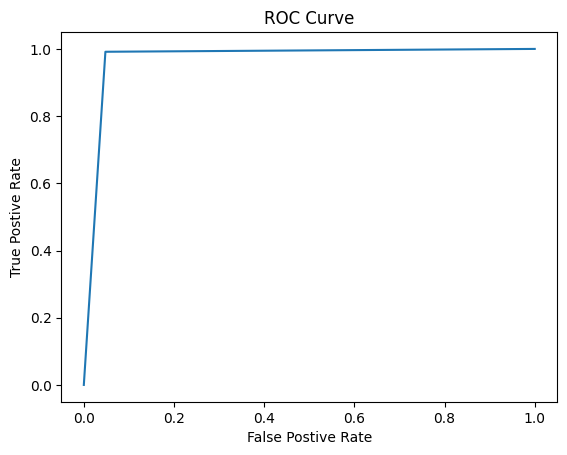

In [113]:
plt.plot(fp, tp)
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('ROC Curve')

# **Real World Set 2**

In [58]:
#Building Second Outside Data set
machine = pd.read_csv('machine-train.csv')
human = pd.read_csv('train_essays.csv')

In [59]:
machine = machine[['text']]
human = human[['text', 'generated']]

In [60]:
machine['generated'] = 1
new_test = pd.concat([machine, human], ignore_index = True)
new_test.head()

,text,generated
0,There are many people who think that universit...,1
1,There are a number of reasons why people might...,1
2,There are many reasons why university educatio...,1
3,There are many people who think that universit...,1
4,There is a general consensus that university e...,1


In [126]:
new_test.shape

(4715, 4)

In [61]:
new_test = add_ins(new_test)
new_matrix = vectoring(new_test)

In [95]:
new_test = remove_abstract(new_test, 'text', pattern)
accuracy_score(new_test['generated'], net_classify.predict(new_matrix))

0.8909862142099682

# **Set 2 Analysis**

In [96]:
#Higher Rate of False Negatives
recall_score(new_test['generated'], net_classify.predict(new_matrix))

0.8464531577372044

In [97]:
#Extremely Low Rate of False Postives
precision_score(new_test['generated'], net_classify.predict(new_matrix))

0.9996465182043125

In [103]:
fp_2, tp_2, holds_2 = roc_curve(new_test['generated'], net_classify.predict(new_matrix))
roc_2 = auc(fp_2, tp_2)
roc_2

0.9228626778496793

Text(0.5, 1.0, 'ROC Curve')

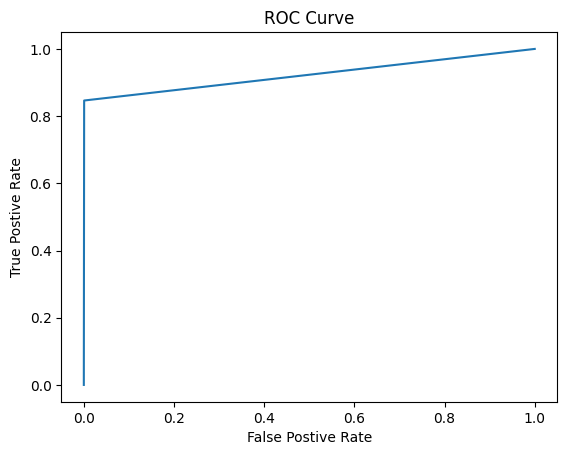

In [124]:
plt.plot(fp_2, tp_2)
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('ROC Curve')

# **Real World Set 3**

In [108]:
#Building a 3rd data set outside scope of training data
other = pd.read_csv('Training_Essay_Data.csv')
other.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


In [128]:
other_copy = pd.read_csv('Training_Essay_Data.csv')
other_copy.shape

(29145, 2)

In [109]:
other = other.sample(8000)

In [110]:
other.shape

(8000, 2)

In [111]:
other = add_ins(other)

In [114]:
other = other.copy().reset_index().drop(columns = 'index')

In [115]:
other_matrix = vectoring(other)

In [116]:
other = remove_abstract(other, 'text', pattern)

In [118]:
accuracy_score(other['generated'], net_classify.predict(other_matrix))

0.9134675503313743

# **Set 3 Analysis**

In [120]:
#Higher Rate of False Negatives
recall_score(other['generated'], net_classify.predict(other_matrix))

0.7957192319798552

In [121]:
#Lower Rate of False Positives
precision_score(other['generated'], net_classify.predict(other_matrix))

0.9832749902761572

In [122]:
fp_3, tp_3, holds_3 = roc_curve(other['generated'], net_classify.predict(other_matrix))
roc_3 = auc(fp_3, tp_3)
roc_3

0.8933990350770645

Text(0.5, 1.0, 'ROC Curve')

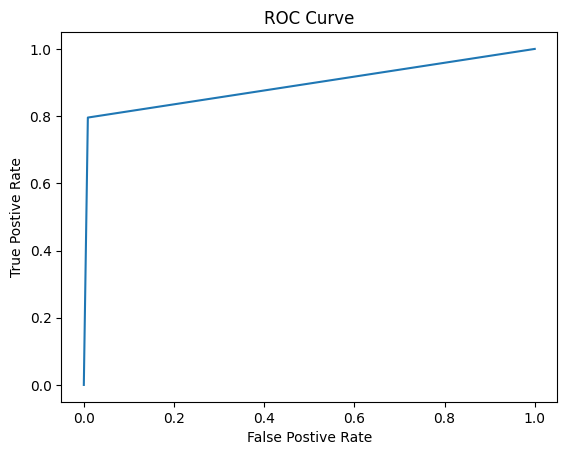

In [123]:
plt.plot(fp_3, tp_3)
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('ROC Curve')